
# Lab 5 - Principal Component Analysis

## Name: Young Bin Jo (yjo10)

## Due: October 3, 2018 at 11:59 PM [Next Wednesday]

### Logistics:

See the <a href="https://courses.engr.illinois.edu/ece398bd/">course website</a>. This is the last lab for this section of the course. Make sure to be up to date for the policies of the second part of the course. **You will have another lab next week and a different TA (who is not familiar with this lab), so it is in your best interests to finish this lab before next week's lab session.**

There will be office hours on Monday, as usual.

### What You Will Need To Know For This Lab:

- Eigendecomposition
- Singular Value Decomposition
- Principal Component Analysis

### Preamble (Don't change this):

In [45]:
%pylab inline
import numpy as np
from sklearn import neighbors
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.decomposition import PCA
from PIL import Image
from sklearn.cluster import KMeans
import scipy.spatial.distance as dist
from matplotlib.colors import ListedColormap

Populating the interactive namespace from numpy and matplotlib


C:\Users\young\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'var', 'cov', 'dist', 'inv']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Enable Interactive Plots

In [46]:
enable_interactive=False # If you want to rotate plots, set this to True. 
# When submitting your notebook, enable_interactive=False and run the whole notebook. 
# The interactive stuff can be a bit glitchy, so if you're having trouble, turn them off. 
if enable_interactive:
    # These packages allow us to rotate plots and what not.
    from IPython.display import display
    from IPython.html.widgets import interact

### Problem 1: Visualizing Principal Components (50 points)

In this problem, you will be implementing PCA, visualizing the principal components and using it to perform dimensionality reduction. 

Do not use a pre-written implementation of PCA for this problem (e.g. sklearn.decomposition.PCA). You should assume that the input data has been appropriately pre-processed to have zero-mean features.

In [47]:
# We will generate some data.
numpy.random.seed(seed=2232017)
true_cov = np.array([[1,.2,.3],[.2,1,.6],[.3,.6,1]]) #This is the true covariance matrix 
                                                     #of the data. Do not use it in your code!
data=(np.random.randn(1000,3)).dot(np.linalg.cholesky(true_cov).T) 

First, we visualize the data using a 3D scatterplot. 

Our data is stored in a variable called `data` where each row is a feature vector (with three features).

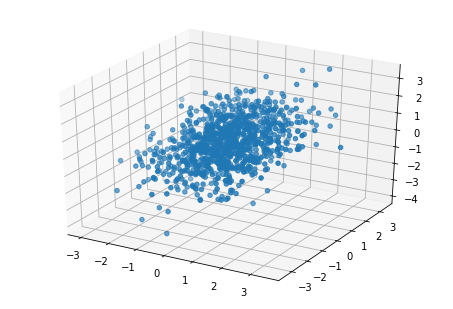

In [48]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data[:,0],data[:,1],data[:,2])
if enable_interactive:
    @interact(elev=(-90, 90), azim=(0, 360))
    def view(elev, azim):
        ax.view_init(elev, azim)
        display(ax.figure)

Write a function which implements PCA via the eigendecomposition. <b>(10 points)</b>

You will be given as input:
- A $(N,d)$ numpy array of data (with each row as a feature vector)

Your function should return a tuple consisting of the PCA transformation matrix (which is $(d,d)$), and a vector consisting of the amount of variance explained in the data by each PCA feature. Note that the PCA features are ordered in decreasing amount of variance explained, by convention.

Hints:
- The function <a href="http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.linalg.eigh.html">numpy.linalg.eigh</a> will be useful. Note that it returns its eigenvalues in *ascending* order. `numpy.fliplr` or similar may be useful as well.
- You can calculate the covariance matrix of the data by multiplying the data matrix with its transpose in the appropriate order, and scaling it. 
- Do not use numpy.cov -- we are assuming the data has zero mean beforehand, so the number of degrees of freedom is different (since the covariance estimate knows the mean in our case). 

In [49]:
def pcaeig(data):
    #Put your code here
    cov = (1/data.shape[0])*(data.T).dot(data)
    eigenval, eigenvec = np.linalg.eigh(cov)
    eigenvec = np.fliplr(eigenvec).T
    eigenval = eigenval[::-1]
    return eigenvec, eigenval

Now, run PCA on your data. Store your PCA transformation in a variable called `W`, and the amount of variance explained by each PCA feature in a variable called `s`. Print out the principal components (i.e. the rows of `W`) along with the corresponding amount of variance explained. <b>(5 points)</b>

In [50]:
# Put your code here
W, s = pcaeig(data)
print(W)
print(s)

[[-0.37919732 -0.6615397  -0.64697343]
 [-0.91750747  0.35945511  0.17021185]
 [-0.119956   -0.65814683  0.74327203]]
[1.77402422 0.81459149 0.38663907]


We can visualize the principal components on top of our data. The first principal component is in red, and captures the most variance. The second principal component is in green, while the last principal component is in yellow.

We generated our data from am *elliptical distribution*, so it should be easy to visualize these components as the axes of the data (which looks like an ellipsoid).

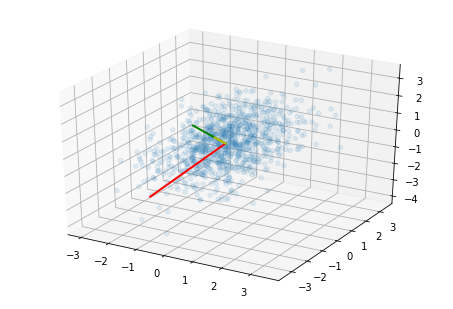

In [51]:
figb = plt.figure()
axb = Axes3D(figb)
axb.scatter(data[:,0],data[:,1],data[:,2],alpha=0.1)
c=['r-','g-','y-']
for var, pc,color in zip(s, W,c):
    axb.plot([0, 2*var*pc[0]], [0, 2*var*pc[1]], [0, 2*var*pc[2]], color, lw=2)
if enable_interactive:
    @interact(elev=(-90, 90), azim=(0, 360))
    def view(elev, azim):
        axb.view_init(elev, azim)
        display(axb.figure)

If done correctly, the red line should be longer than the green line which should be longer than the yellow line.

Now, you will implement functions to generate PCA features.

Write a function which implements dimension reduction via PCA. It takes in three inputs:
- A $(N,d)$ numpy array, `data`, with each row as a feature vector
- A $(d,d)$ numpy array, `W`, the PCA transformation matrix (e.g. generated from `pcaeig` or `pcasvd`)
- A number `k`, which is the number of PCA features to retain

It should return a $(N,k)$ numpy array, where the $i$-th row contains the PCA features corresponding to the $i$-th input feature vector. <b>(5 points)</b>

In [52]:
def pcadimreduce(data,W,k):
    # Put your code here
    Wk = W[0:k,:]
    pcadata = data.dot(Wk.T)
    return pcadata

Write a function which reconstructs the original features from the PCA features. It takes in three inputs:
- A $(N,k)$ numpy array, `pcadata`, with each row as a PCA feature vector (e.g. generated from `pcadimreduce`)
- A $(d,d)$ numpy array, `W`, the PCA transformation matrix (e.g. generated from `pcaeig` or `pcasvd`)
- A number `k`, which is the number of PCA features

It should return a $(N,d)$ numpy array, where the $i$-th row contains the reconstruction of the original $i$-th input feature vector (in `data`) based on the PCA features contained in `pcadata`. <b>(5 points)</b>

In [53]:
def pcareconstruct(pcadata,W,k):
    # Put your code here
    Wk  = W[0:k,:]
    orig = pcadata.dot(Wk)
    return orig

As a sanity check, if you take $k=3$, perform dimensionality reduction then reconstruction, you should get the original data back:

In [54]:
# Reconstructed data using all the principal components
reduced_data=pcadimreduce(data,W,3)
reconstructed_data=pcareconstruct(reduced_data,W,3)

print ("This should be small:",np.max(np.abs(data-reconstructed_data)))

This should be small: 8.881784197001252e-16


One use of PCA is to help visualize data. The 3-D plots above are a bit hard to read on a 2-D computer screen or when printed out. 

Use PCA to to reduce the data to two dimensions. Visualize the first two PCA features with a scatter plot. Also, construct an approximation of the original features using the first two principal components into a $(N,d)$ array called `reconstructed_data`.<b>(10 points)</b>

In [55]:
#Put your code here

reduced_data = pcadimreduce(data,W,2)
reconstructed_data = pcareconstruct(reduced_data,W,2)

We can now visualize the data using two principal components in the original feature space.

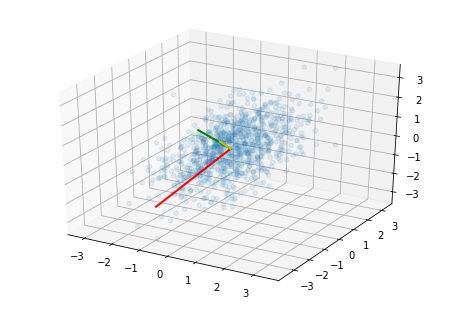

In [56]:
figc = plt.figure()
axc = Axes3D(figc)
axc.scatter(reconstructed_data[:,0],reconstructed_data[:,1],reconstructed_data[:,2],alpha=0.1)
c=['r-','g-','y-']
for var, pc,color in zip(s, W,c):
    axc.plot([0, 2*var*pc[0]], [0, 2*var*pc[1]], [0, 2*var*pc[2]], color, lw=2)
    
if enable_interactive:
    @interact(elev=(-90, 90), azim=(0, 360))
    def view(elev, azim):
        axc.view_init(elev, azim)
        display(axc.figure)

If done correctly, you should see no component of the data along the third principal direction, and the data should lie in a plane. This may be easier to see with the Interactive Mode on. 

Use PCA to reduce the data to one dimension and store the one dimensional PCA feature in `reduced_data_1`. Construct an approximation of the original features using the first  principal component into a $(N,d)$ array called `reconstructed_data_1`. <b>(5 points)</b>

In [57]:
#Put your code here
reduced_data_1 = pcadimreduce(data, W, 1)
reconstructed_data_1 = pcareconstruct(reduced_data_1, W, 1)

We can now visualize this in the original feature space. 

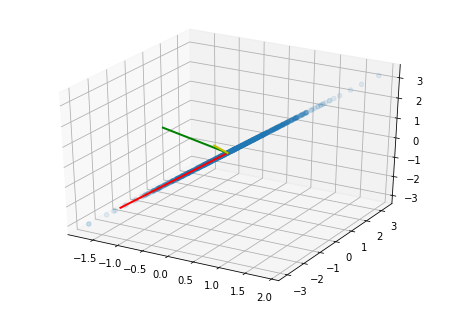

In [58]:
figd = plt.figure()
axd = Axes3D(figd)
axd.scatter(reconstructed_data_1[:,0],reconstructed_data_1[:,1],reconstructed_data_1[:,2],alpha=0.1)
c=['r-','g-','y-']
for var, pc,color in zip(s, W,c):
    axd.plot([0, 2*var*pc[0]], [0, 2*var*pc[1]], [0, 2*var*pc[2]], color, lw=2)
    
if enable_interactive:
    @interact(elev=(-90, 90), azim=(0, 360))
    def view(elev, azim):
        axd.view_init(elev, azim)
        display(axd.figure)

If done correctly, you should see no component of the data along the second and third principal direction, and the data should lie along a line. This may be easier with the Interactive Mode on. 

We can also visualize the PCA feature as a histogram:

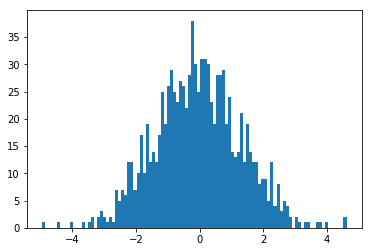

In [59]:
n, bins, patches = hist(reduced_data_1,100)

Finally, you will implement PCA via the SVD. <b>(5 points)</b>

You will be given as input:
- A $(N,d)$ numpy array of data (with each row as a feature vector)

Your function should return a tuple consisting of the PCA transformation matrix, and a vector consisting of the amount of variance explained in the data by each PCA feature. Note that the PCA features are ordered in decreasing amount of variance explained.

Hints:
- The function <a href="http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.linalg.svd.html">numpy.linalg.svd</a> will be useful. Use the full SVD (default).
- Be careful with how the SVD is returned in `numpy.linalg.svd` (`V` in numpy is the transpose of what is in the notes). 

In [60]:
def pcasvd(data):
    #Put your code here
    u, s, V = np.linalg.svd(data)
    cov = (1/data.shape[0])*(s*s)

    return V,cov

If your PCA implementation via the SVD is correct (and your Eigendecomposition implementation is correct), principal components should match between the SVD and PCA implementations (up to sign, i.e. the i-th principal component may be the negative of the i-th principal component from the eigendecomposition approach). 

Verify this by printing out the principal components and the corresponding amount of variance explained. You will not get any credit if the principal components (up to sign) and variances do not match the eigendecomposition. <b>(5 points)</b>

In [61]:
# Put your code here
V,cov = pcasvd(data)
print(W)
print(cov)

[[-0.37919732 -0.6615397  -0.64697343]
 [-0.91750747  0.35945511  0.17021185]
 [-0.119956   -0.65814683  0.74327203]]
[1.77402422 0.81459149 0.38663907]


### Problem 2: PCA for Data Compression (30 points)

In class, you saw an example application of PCA to create eigenfaces. In this part of the lab, we will look at eigenfaces for compression using the <a href="http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html">Olivetti faces dataset</a>. 

In [37]:
# First, we load the Olivetti dataset
from sklearn.datasets import fetch_olivetti_faces


oli = fetch_olivetti_faces()
# Height and Width of Images are in h,w. You will need to reshape them to this size display them.
h=64
w=64
X = oli.data

X_t=X[-1]
X=X[:-1]

#This centering is unnecessary. it just makes the pictures a bit more readable. 

X_m=np.mean(X,axis=0)
X=X-X_m # center them
X_t=X_t-X_m

# The data set is in X. You will compress the image X_t. 

We can visualize the Olivetti Faces:
<img src="olivettifaces.gif"></img>

We will be making use of Scikit-Learn's <a href="http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html">PCA</a> functionality. 

Three functions will be useful for this problem :
- PCA.fit : Finds the requested number of principal components.
- PCA.transform : Apply dimensionality reduction (returns the PCA features)
- PCA.inverse_transform : Go from PCA features to the original features (Useful for visualizing)

You will also find the following useful:
- PCA.explained\_variance\_ratio\_ : Percentage of variance explained by each of the principal components

Plot the fraction of **unexplained** variance on `X` by PCA retaining the first $k$ principal components, where  $k=1,\ldots,200$. Note that this is a scree plot (normalized by the total variance). 

`numpy.cumsum` may be useful for this. <b>(10 points)</b>

(0, 200)

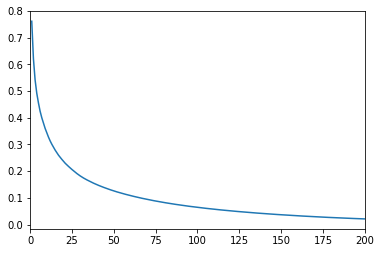

In [38]:
# Put your code here

pca=PCA(n_components=200)
pca.fit(X)

explained = pca.explained_variance_ratio_
unexplained = 1 - np.cumsum(explained)

pylab.plot(np.arange(1,201, 1),unexplained)
pylab.xlim(0,200)

Based on the Scree plot, propose a reasonable number of principal components to keep, in order to perform dimensionality reduction. Justify your choice. <b>(5 points)</b>

There is a range of correct answers (but you need to justify yours!). 

[I would pick k value as 100. Most of variance is taken up to k = 100]

Visualize the first 5 principal components as well as the 30th, 50th and 100th principal components, which are called *eigenfaces* in this context. Assuming your PCA object is called `pca`, the eigenfaces are contained in `pca.components_`, where each row is a principal component. 

The following code from Lab 4 may be useful:

    figure()
    imshow( image , cmap = cm.Greys_r)
    
where image is the appropriately reshaped principal component (to `h` rows and `w` columns). What can you say about later eigenfaces compared to earlier ones? <b>(5 points)</b>

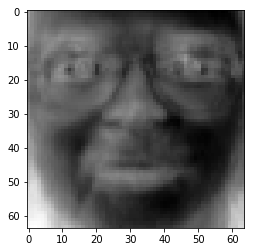

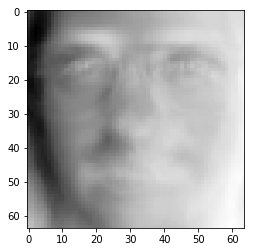

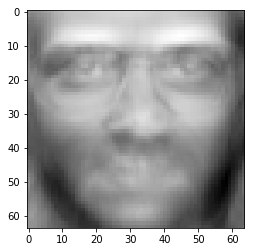

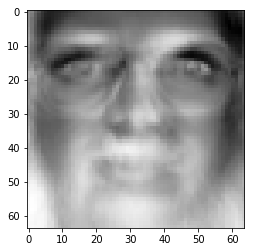

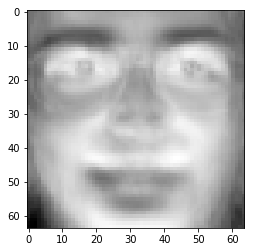

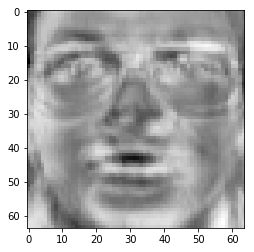

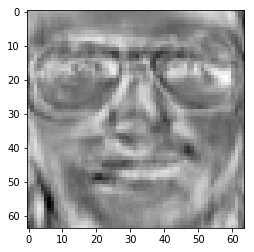

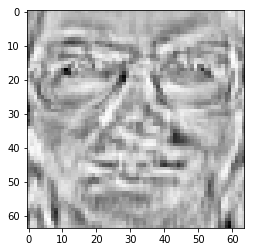

In [39]:
# Put your code here
for i in [1,2,3,4,5,30,50,100]:
    pca=PCA()
    pca.fit(X)
    image=pca.components_[i-1,:].reshape(64,64)
    figure()
    imshow(image, cmap = cm.Greys_r)

Later eigenfaces capture more detail as compared to earlier ones (e.g. they're specific to some guy). Later eigenfaces get less blurry

Now, you will compress an image, `X_t`, using PCA. 

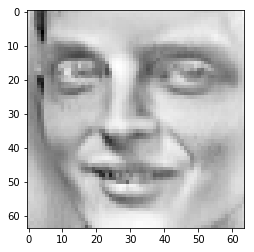

In [40]:
# This is what X_t looks like:
imshow((X_t).reshape((h,w)),cmap=cm.Greys_r)

Display the image in `X_t`'s approximation using the first `i` principal components (learned from `X`)  where i=1,10,20,...,100 (i.e. in increments of 10), then 120,140,160,180,200 (i.e. in increments of 20).

Do this by the following procedure:
1. Determine the PCA transformation (i.e. fit) on `X`. 
2. Transform `X_t` to the PCA features determined by `X`.
3. Retain the first `i` PCA features of the transformed `X_t` (set the others to zero). 
4. Transform the result of step 3 back to the original feature space. 

<b>(5 points)</b>

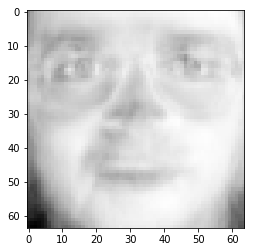

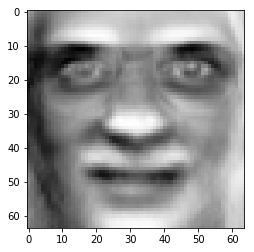

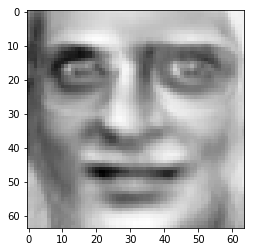

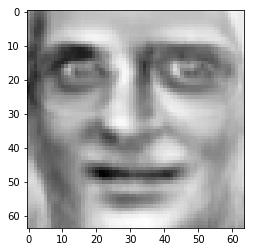

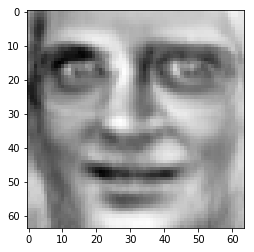

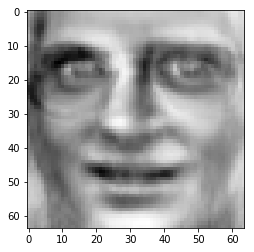

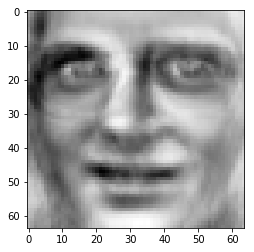

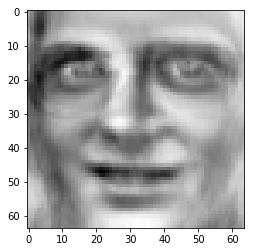

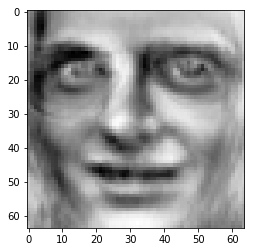

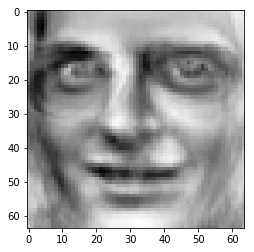

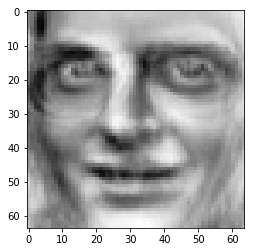

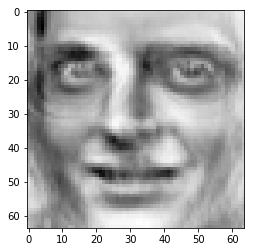

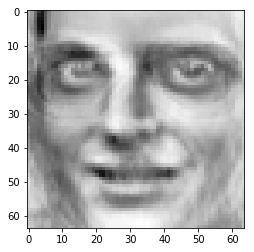

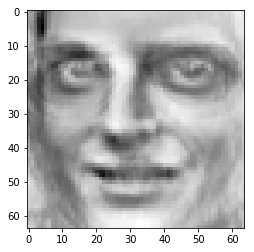

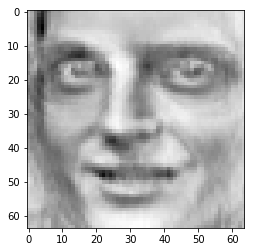

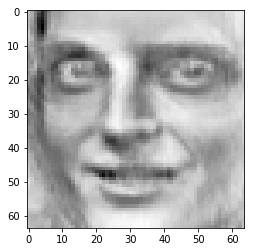

In [64]:
# Put your code here.
for i in [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200]:
    pca=PCA(n_components=i)
    pca.fit(X)
    transform=pca.transform(X_t.reshape(1,-1))
    inv=pca.inverse_transform(transform)
    image=inv.reshape(h,w)
    figure()
    imshow(image, cmap = cm.Greys_r)


How many principal components would you keep to compress the image? Why? (You may be qualitative or quantitative) <b>(5 points)</b>

[I would choose 120 principal components. After 120 principle components, I do not see major difference in image even we increase principle components. However, if we increase principal components, it uses more resources which is inefficient]

### Problem 3: PCA for Classification (20 points)

First, we will load a data set of digits drawn from zip codes written on US mail. This data set was designed to help get good algorithms to sort mail by zip code automatically. It has been preprocessed a bit, with details given <a href="http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/zip.info.txt">here</a>. Each feature vector consists of real values representing grayscale values of a 16 by 16 image of a digit. The training data has 7291 samples, while the validation data has 2007 samples. Note that this is not the same dataset built into scikit- learn -- it is much larger. Use sklearn.decomposition.PCA for this problem. 

In [42]:
#Loading the Data
#Read in the Training Data
traindata_tmp= genfromtxt('zip.train', delimiter=' ')
#The training labels are stored in "trainlabels", training features in "traindata"
trainlabels=traindata_tmp[:,0]
traindata=traindata_tmp[:,1:]
#Read in the Validation Data
valdata_tmp= genfromtxt('zip.val', delimiter=' ')
#The validation labels are stored in "vallabels", validation features in "valdata"
vallabels=valdata_tmp[:,0]
valdata=valdata_tmp[:,1:]

In Lab 2, you found that the validation error on this data set was 0.056 for 1-NN. 

Make a plot of the validation error using 1-NN on the PCA features using 1,2,...,256 PCA features. What is the minimum validation error, and how many PCA features did you use? <b>(10 points)</b>

0.04882909815645242
39


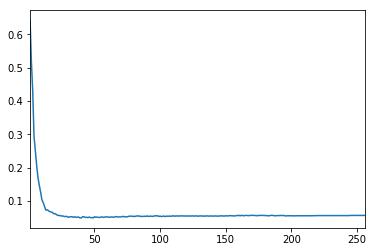

In [65]:
#Put your code here
error = np.zeros(256)
features = np.arange(1,257, 1)


for feat in features:
    pca = PCA(n_components = feat)
    pca.fit(traindata)
    
    reduced_tdata = pca.transform(traindata)
    reduced_vdata = pca.transform(valdata)

    neigh = neighbors.KNeighborsClassifier(n_neighbors = 1)
    neigh.fit(reduced_tdata, trainlabels)
    
    error[feat - 1] = 1 - neigh.score(reduced_vdata, vallabels)

pylab.plot(features,error)
pylab.xlim(1,256)

print(np.min(error))
print(np.argmin(error)+1)

[Error = 0.04882909815645242] <br>
[39 features]

Does PCA+NN give better or worse performance than just NN? Why do you think this is? Which would you choose (and if using PCA, with how many features)? Take into account both computational costs and error in your answer. <b>(10 points)</b>

[It gives better performance. This mainly happens because PCA by itself lose data when it computes reduction. I would choose PCA+NN with 39 components. However as a computational cost, PCA+NN takes more resources]

### Problem 4 (Optional): Spectral Clustering (20 bonus points)

In this problem, you will implement a powerful clustering algorithm known as spectral clustering. It can separate data that in some cases, K-means cannot (as you will see in this problem).

Spectral clustering works by forming a graph based on similarities between data vectors, and looking for cluster of data vectors such that the similarity between them is high, but the similarity to vectors outisde the clusters is low (and the clusters aren't too small).

See Section 4.3 in the notes for details on how it works, or [this tutorial](https://arxiv.org/abs/0711.0189). 

**The Spectral Clustering Algorithm (Alg. 9):**


1. Let $\tilde{L} = I - D^{-1/2} S D^{-1/2}$ where $D^{-1/2}$ is a square diagonal matrix with $\frac{1}{\sqrt{d_i}}$ as the $i$-th entry on the diagonal (where $\mathbf{d} = S \mathbf{1}$). 
2. Take the eigen-decomposition of $\tilde{L}= U \Lambda U^\top$ where $\Lambda$ is a diagonal matrix containing the eigenvalues of $L$.
3. Let $U_K$ be a matrix whose columns are the eigenvectors corresponding to the $K$-smallest eigenvalues of $L$.
4. Normalize each row of $U_K$ (i.e. divide each entry on the $i$-th row by the norm of the $i$-th row)
5. Apply K-means clustering to the rows of $U_K$ (i.e. treat each row of $U_K$ as a $K$-dimensional feature vector and cluster it). 
6. Return the cluster labels from step $4$. $\mathbf{x}_i$ is assigned to the cluster which the $i$-th row of $U_K$ was assigned to. 

$L$ is known as the normalized Laplacian of the similarity graph, and has many nice properties for analyzing the similarity graph, most of which are beyond the scope of the course. 

**Note: You don't really need to know why spectral clustering works to do this problem (though it would be nice) -- you just need to be able to implement the algorithm.**

First, I'll make a data set based on the Illinois logo.

In [ ]:
tmp=np.nonzero(np.asarray(
[[1,1,1,1,1,1,1,1,1,1,1,1],
[1,0,0,0,0,0,0,0,0,0,0,1],
[1,0,0,0,0,0,0,0,0,0,0,1],
[1,0,0,1,1,1,1,1,1,0,0,1],
[1,0,0,0,0,1,1,0,0,0,0,1],
[1,0,0,0,0,1,1,0,0,0,0,1],
[1,0,0,0,0,1,1,0,0,0,0,1],
[1,0,0,1,1,1,1,1,1,0,0,1],
[1,0,0,0,0,0,0,0,0,0,0,1],
[1,0,0,0,0,0,0,0,0,0,0,1],
[1,1,1,1,1,1,1,1,1,1,1,1]]))

illcmap=ListedColormap(['#131F33','#FA6300'])

data=np.c_[tmp[1],tmp[0]]
figure()
scatter(data[:,0],data[:,1])

Let us first see what happens if we try to cluster these points using K-means to get 2 clusters. 

Use `sklearn.cluster.KMeans` to cluster these points into two clusters. 

Plot the clusters using the colors as the labels you get from K-means clustering as a scatter plot, with `cmap=illcmap`. **(5 points)**

In [ ]:
#Put your code here

If done correctly, you should see something like the right half of the points are in one cluster, and the left half are in the other. The Illinois I should not be separated from the perimeter. In general, K-means cannot produce non-convex clusters (i.e. if you draw a line between any 2 points in a cluster, any point that lies on that line is in that cluster), so it cannot separate the I from the border.

Now, implement spectral clustering as described above. 

Recall that `numpy.linalg.eigh` returns the eigenvalues of a matrix in *ascending* order.

The code provided already calculates $L$. **(10 points)**

In [ ]:
def spectralClustering(data,K,C=1):
    W=np.exp(-dist.cdist(data,data,'sqeuclidean')/C)
    W=W-np.diag(np.diag(W))
    Dinv5=np.diag( (W.dot(np.ones(W.shape[0])))**(-0.5) )
    L=np.eye(W.shape[0])-Dinv5.dot(W).dot(Dinv5)
# Put your code here

Now, run your spectral clustering implementation with 2 clusters on the data in `data`, and plot the data with the colors given by the clusters returned by `spectralClustering` with `cmap=illcmap`. **(5 points)**

In [ ]:
#Put your code here

The default value of $C=1$ in the spectral clustering code should separate the I from the border (though which will be colored orange and which will be blue will be random).

Since you're doing audio and visual analytics next, I thought I'd leave you with something on that note.

You can find a demo of Spectral Clustering applied to image segmentation based on 

Shi, Jianbo, and Jitendra Malik. "Normalized cuts and image segmentation." IEEE Transactions on pattern analysis and machine intelligence 22.8 (2000): 888-905.

at http://scikit-learn.org/stable/auto_examples/cluster/plot_face_segmentation.html.

# And this concludes the Machine Learning section of the course! Good luck with your future endeavors!